In [20]:
from vrplib import read_solution
def compareTrueSol(file_path, result_cost):
    BKS = read_solution(file_path)
    gap = 100 * (result_cost - BKS["cost"]) / BKS["cost"]
    print(f"Found a solution with cost: {result_cost}.")
    print(f"This is {gap:.1f}% worse than the best known", end=" ")
    print(f"solution, which is {BKS['cost']}.")
    return gap

# pyVRP
from pyvrp import read
from pyvrp import Model
from pyvrp.stop import MaxIterations

def use_PyVRP(file_name, basePath = "./data"):
    INSTANCE = read(basePath + "/" + file_name + ".vrp", round_func="round")
    model = Model.from_data(INSTANCE)
    result = model.solve(stop=MaxIterations(2000), seed=10)
    print("PyVRP")
    gap = compareTrueSol(basePath + "/" + file_name + ".sol", result.cost())
    return result,gap



In [21]:
# routingblocks
import random
from pathlib import Path
from typing import List

import routingblocks
import routingblocks_cvrp as cvrp
import vrplib
def read_instance(instance_name: str, basedir: Path = Path('instances/')):
    instance_file = basedir / instance_name
    if not instance_file.exists():
        basedir.mkdir(parents=True, exist_ok=True)
        # Download the CVRP problem instance if it does not exist
        vrplib.download_instance(instance_name, str(instance_file))

    # Load the CVRP problem instance
    return vrplib.read_instance(instance_file)

def create_cvrp_instance(instance):
    # Create CVRP vertices
    n = len(instance['demand'])
    vertices = [
        cvrp.create_cvrp_vertex(i, str(i), False, i == instance['depot'][0], cvrp.CVRPVertexData(instance['demand'][i]))
        for i in range(n)]
    # Create CVRP arcs
    arcs = [
        [cvrp.create_cvrp_arc(cvrp.CVRPArcData(instance['edge_weight'][i][j])) for j in range(n)] for i in range(n)
    ]

    return routingblocks.Instance(vertices, arcs, len(vertices))

def optimize_solution(evaluation: routingblocks.Evaluation, instance: routingblocks.Instance,
                      solution: routingblocks.Solution):
    # Create a local search solver
    solver = routingblocks.LocalSearch(instance, evaluation, evaluation, routingblocks.BestImprovementPivotingRule())
    # Create some operators
    # Create the arc set - by default all arcs are included
    full_arc_set = routingblocks.ArcSet(len(instance))
    operators = [
        routingblocks.operators.SwapOperator_0_1(instance, full_arc_set),
        routingblocks.operators.SwapOperator_1_1(instance, full_arc_set),
        routingblocks.operators.InterRouteTwoOptOperator(instance, full_arc_set)
    ]
    # Optimize the solution (inplace)
    solver.optimize(solution, operators)
    return solution

def distribute_randomly(sequence, num_subsequences: int, randgen=random.Random()) -> List[List]:
    subsequences = [[] for _ in range(num_subsequences)]
    for item in sequence:
        subsequences[randgen.randint(0, len(subsequences) - 1)].append(item)
    return subsequences


def generate_random_solution(evaluation: routingblocks.Evaluation, instance: routingblocks.Instance,
                             random: routingblocks.Random):
    customers = [x.vertex_id for x in instance.customers]
    sol = routingblocks.Solution(evaluation, instance,
                                 [routingblocks.create_route(evaluation, instance, r) for r in
                                  distribute_randomly(customers, instance.fleet_size,
                                                      random)])
    return sol

import time

def use_routingBlocks(file_name, basePath = "./data"):
    basedir = Path(basePath)
    instance = read_instance(instance_name=file_name + ".vrp", basedir=basedir)
    cpp_instance = create_cvrp_instance(instance)
    evaluation = cvrp.CVRPEvaluation(instance['capacity'])
    max_demand = instance['demand'].max()
    max_dist = instance['edge_weight'].max()
    evaluation.overload_penalty_factor = max_dist / max_demand
    # Create a simple solution by applying local search to a random solution
    randgen = routingblocks.Random(10)
    t1  = time.time()
    random_solution = generate_random_solution(evaluation, cpp_instance, randgen)
    optimized_solution = optimize_solution(evaluation, cpp_instance, random_solution)
    t = time.time() - t1
    print("routingblocks")
    gap = compareTrueSol(basePath + "/" +file_name + ".sol", optimized_solution.cost)
    return optimized_solution, t, gap

In [3]:
# VRPSolverEasy

import numpy as np
import VRPSolverEasy

def read_file_for_easy(file_path):
    f = open(file_path, "r")

    capacity = 0
    depot_index = []
    coordinate_section = False
    demand_section = False
    depot_section = False

    coodinates = []
    parameters = []

    for l in f.readlines():
        if "CAPACITY :" in l:
            capacity = int(l.split("CAPACITY :")[-1])
            continue

        elif "NODE_COORD_SECTION" in l:
            coordinate_section = True
            demand_section = False
            depot_section = False
            continue

        elif "DEMAND_SECTION" in l:
            coordinate_section = False
            demand_section = True
            depot_section = False
            continue

        elif "DEPOT_SECTION" in l:
            coordinate_section = False
            demand_section = False
            depot_section = True
            continue

        elif "EOF" in l:
            break

        
        if coordinate_section:
            coordinate = l.split()[1:]
            coordinate = [float(_) for _ in coordinate]
            coodinates.append(coordinate)
            continue
        
        if demand_section:
            demand = [int(l.split()[-1]),0,0,0,0]
            parameters.append(demand)
            continue

        if depot_section:
            number = int(l.split()[-1])
            if number != -1:
                depot_index.append(number)

    coodinates = np.array(coodinates)
    parameters = np.array(parameters)
    return coodinates, parameters, capacity

def build_distance_matrix(coordinates):
   a = coordinates
   b = a.reshape(np.prod(a.shape[:-1]), 1, a.shape[-1])
   return np.sqrt(np.einsum('ijk,ijk->ij',  b - a,  b - a)).squeeze()

def getModel(file_name, base_path = "./data"):
    coordinates, parameters, capacity = read_file_for_easy(base_path + "/" + file_name + ".vrp")
    fleet_size = int(file_name.split("-")[-1][1:])
    distance_matrix = build_distance_matrix(coordinates)

    # get distance and create model
    model = VRPSolverEasy.Model()
    n_rows = coordinates.shape[0]
    for id in range(n_rows):
        demand, tw_begin, tw_end, service_time, penalty = parameters[id]
        demand = demand.item()
        tw_begin = tw_begin.item()
        tw_end = tw_end.item()
        service_time = service_time.item()
        penalty = penalty.item()
        if id == 0:
            model.add_depot(id = id, name="depot", service_time=service_time, tw_begin=tw_begin,tw_end = tw_end)
        else:
            model.add_customer(id = id, id_customer = id, name='customer_{}'.format(id), demand=demand, penalty=penalty, service_time = service_time, tw_begin=tw_begin, tw_end = tw_end)
    n_rows,n_col = distance_matrix.shape
    point_list = model.points
    for id_from in range(n_rows):
        distance_data = distance_matrix[id_from]
        name_from = point_list[id_from].name
        for id_to in range(id_from+1, n_col):
            name_to = point_list[id_to].name
            model.add_link(start_point_id=id_from, end_point_id= id_to, name="{}--{}".format(name_from, name_to), is_directed=False, distance=distance_data[id_to])

    model.add_vehicle_type(id=1, start_point_id=0, end_point_id=0, name="vehicle1", capacity=capacity, max_number=fleet_size, fixed_cost=0, var_cost_dist=1)
    model.set_parameters(solver_name="CLP")
    return model

def use_EasySolver(file_name, base_path = "./data", known_feasible_solution = 0):
    model = getModel(file_name, base_path)
    if known_feasible_solution != 0:
        model.parameters.upper_bound = known_feasible_solution
    
    model.solve()
    if (model.solution.is_defined()):
        compareTrueSol(base_path + "/" +file_name + ".sol", model.solution.value)
    return model.solution

In [7]:
result_pyvrp = use_PyVRP("X-n106-k14")
# result_rb =  use_routingBlocks("X-n491-k59")

PyVRP
Found a solution with cost: 26448.
This is 0.3% worse than the best known solution, which is 26362.


In [8]:
result_es = use_EasySolver("X-n106-k14", known_feasible_solution = result_pyvrp.cost())

In [9]:
result_es2 = use_EasySolver("X-n106-k14")

Found a solution with cost: 26373.047446769713.
This is 0.0% worse than the best known solution, which is 26362.


In [38]:
file_name_list = []

import os
for i in os.listdir("./data"):
    if ".sol" in i:
        continue
    
    file_name = i.split(".vrp")[0]
    n = int(file_name.split("-")[1][1:])
    if (100<=n<=400):
        file_name_list.append(file_name)


In [39]:
pyvrp_time = []
pyvrp_cost = []
rb_time = []
rb_cost = []
for j in file_name_list:
    result_pyvrp,gap1 = use_PyVRP(j)
    pyvrp_time.append(result_pyvrp.runtime)
    pyvrp_cost.append(gap1)
    result_rb, t_0,gap2 =  use_routingBlocks(j)
    rb_time.append(t_0)
    rb_cost.append(gap2)

PyVRP
Found a solution with cost: 27591.
This is 0.0% worse than the best known solution, which is 27591.
routingblocks
Found a solution with cost: 28387.443359375.
This is 2.9% worse than the best known solution, which is 27591.
PyVRP
Found a solution with cost: 26448.
This is 0.3% worse than the best known solution, which is 26362.
routingblocks
Found a solution with cost: 27299.8828125.
This is 3.6% worse than the best known solution, which is 26362.
PyVRP
Found a solution with cost: 14971.
This is 0.0% worse than the best known solution, which is 14971.
routingblocks
Found a solution with cost: 16224.06640625.
This is 8.4% worse than the best known solution, which is 14971.
PyVRP
Found a solution with cost: 12750.
This is 0.0% worse than the best known solution, which is 12747.
routingblocks
Found a solution with cost: 13893.0234375.
This is 9.0% worse than the best known solution, which is 12747.
PyVRP
Found a solution with cost: 13343.
This is 0.1% worse than the best known solut

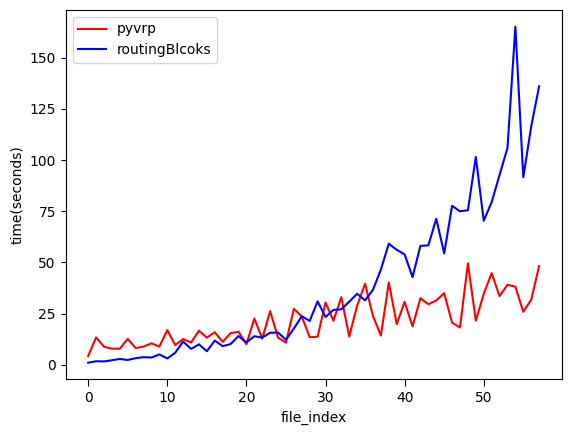

In [44]:
import matplotlib.pyplot as plt

x = [i for i in range(len(file_name_list))]

plt.figure()
plt.xlabel("file_index")
plt.ylabel("time(seconds)")
plt.plot(x, pyvrp_time, 'r', label = "pyvrp")
plt.plot(x, rb_time, 'b', label = "routingBlcoks")
plt.tick_params(axis='x', length = 5)
plt.legend()
plt.show()

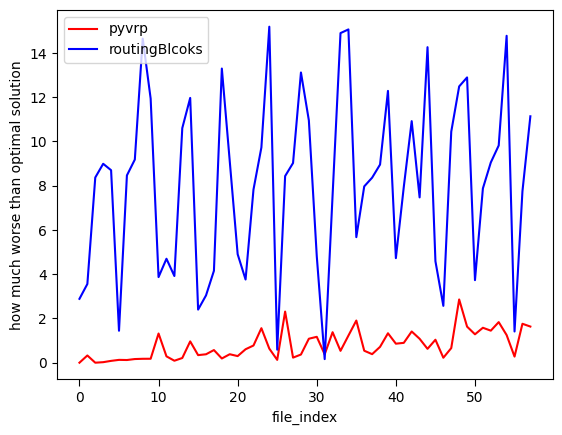

In [46]:
import matplotlib.pyplot as plt

x = [i for i in range(len(file_name_list))]

plt.figure()
plt.xlabel("file_index")
plt.ylabel("how much worse than optimal solution")
plt.plot(x, pyvrp_cost, 'r', label = "pyvrp")
plt.plot(x, rb_cost, 'b', label = "routingBlcoks")
plt.tick_params(axis='x', length = 5)
plt.legend()
plt.show()